<a href="https://colab.research.google.com/github/RaphaelUCL/all/blob/main/Option_Greeks_Visualiser_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Option Greeks Visualiser

This repository contains Python code that demonstrates how to:
- Calculate European option prices under the Black-Scholes model,
- Compute the standard Greeks (Delta, Gamma, Vega, Theta, Rho),
- Visualise these Greeks in 2D and 3D (static and interactive).

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from scipy.stats import norm
import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

## 1. Black-Scholes Functions
The Black-Scholes model for European options relies on two primary parameters, d1 and d2, derived from the underlying asset price
𝑆, strike price
𝐾
, time to maturity
𝑇
, risk-free rate
𝑟
, and volatility
𝜎
. Using these, we can calculate call and put option prices.

###1.1. d1 and d2

These helper functions calculate the standard Black-Scholes d1 and d2 values, used in the formula for option pricing and Greeks.

In [4]:
def d1(S, K, T, r, sigma):
    """
    Calculate d1 parameter for Black-Scholes formula

    Parameters:
    -----------
    S : float
        Current stock price
    K : float
        Strike price
    T : float
        Time to maturity (in years)
    r : float
        Risk-free interest rate (annualised)
    sigma : float
        Volatility (annualised)

    Returns:
    --------
    float : d1 parameter value
    """
    return (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))

def d2(S, K, T, r, sigma):
    """
    Calculate d2 parameter for Black-Scholes formula

    Parameters:
    -----------
    Same as above (S, K, T, r, sigma)

    Returns:
    --------
    float : d2 parameter value
    """
    return d1(S, K, T, r, sigma) - sigma * np.sqrt(T)


###1.2. European Call and Put Prices
Given d1 and d2, these functions compute the Black-Scholes prices for European call and put options. If
𝑇
≤
0
, we return the intrinsic value (the immediate payoff).

In [5]:
def bs_call_price(S, K, T, r, sigma):
    """
    Calculate Black-Scholes price for European call option
    """
    if T <= 0:
        return max(0, S - K)

    D1 = d1(S, K, T, r, sigma)
    D2 = d2(S, K, T, r, sigma)

    return S * norm.cdf(D1) - K * np.exp(-r * T) * norm.cdf(D2)

def bs_put_price(S, K, T, r, sigma):
    """
    Calculate Black-Scholes price for European put option
    """
    if T <= 0:
        return max(0, K - S)

    D1 = d1(S, K, T, r, sigma)
    D2 = d2(S, K, T, r, sigma)

    return K * np.exp(-r * T) * norm.cdf(-D2) - S * norm.cdf(-D1)


##2. Greeks calculaion

Option Greeks measure how sensitive an option’s price is to various parameters. For example, Delta tracks how the option’s price changes with respect to the underlying asset price, whereas Vega measures sensitivity to changes in volatility.

###2.1 Delta
Delta (Δ)
 is the rate of change of the option price with respect to the underlying asset price
𝑆
.

In [6]:
def delta_call(S, K, T, r, sigma):
    """Calculate Delta for call option"""
    if T <= 0:
        return 1.0 if S > K else 0.0
    return norm.cdf(d1(S, K, T, r, sigma))

def delta_put(S, K, T, r, sigma):
    """Calculate Delta for put option"""
    if T <= 0:
        return -1.0 if S < K else 0.0
    return -norm.cdf(-d1(S, K, T, r, sigma))


### 2.2 Gamma

Gamma (
Γ
) measures how Delta changes as
𝑆
 changes (second derivative of the option price with respect to
𝑆
).

In [7]:
def gamma(S, K, T, r, sigma):
    """Calculate Gamma (same for call and put)"""
    if T <= 0:
        return 0.0
    D1 = d1(S, K, T, r, sigma)
    return norm.pdf(D1) / (S * sigma * np.sqrt(T))


###2.3 Vega

Vega measures sensitivity of the option price to changes in volatility
𝜎
.

In [8]:
def vega(S, K, T, r, sigma):
    """Calculate Vega (same for call and put)"""
    if T <= 0:
        return 0.0
    D1 = d1(S, K, T, r, sigma)
    return S * np.sqrt(T) * norm.pdf(D1) / 100


### 2.4 Theta

Theta (
Θ
) measures how the option price decays as time passes, often reported on a per-day basis.

In [19]:
def theta_call(S, K, T, r, sigma):
    """Calculate Theta for call option"""
    if T <= 0:
        return 0.0
    D1 = d1(S, K, T, r, sigma)
    D2 = d2(S, K, T, r, sigma)

    part1 = -S * norm.pdf(D1) * sigma / (2 * np.sqrt(T))
    part2 = -r * K * np.exp(-r * T) * norm.cdf(D2)

    return (part1 + part2) / 365

def theta_put(S, K, T, r, sigma):
    """Calculate Theta for put option"""
    if T <= 0:
        return 0.0
    D1 = d1(S, K, T, r, sigma)
    D2 = d2(S, K, T, r, sigma)

    part1 = -S * norm.pdf(D1) * sigma / (2 * np.sqrt(T))
    part2 = r * K * np.exp(-r * T) * norm.cdf(-D2)

    return (part1 + part2) / 365


### 2.5 Rho

Rho (
𝜌
) captures how the option price changes in response to variations in the risk-free interest rate
𝑟
.

In [20]:
def rho_call(S, K, T, r, sigma):
    """Calculate Rho for call option"""
    if T <= 0:
        return 0.0
    D2 = d2(S, K, T, r, sigma)
    return K * T * np.exp(-r * T) * norm.cdf(D2) / 100

def rho_put(S, K, T, r, sigma):
    """Calculate Rho for put option"""
    if T <= 0:
        return 0.0
    D2 = d2(S, K, T, r, sigma)
    return -K * T * np.exp(-r * T) * norm.cdf(-D2) / 100


## 3. Visualisation Functions

We provide three types of plots for each Greek: a 2D line plot (vs. strike price), a 3D surface plot (vs. strike and maturity), and a 2D heatmap (also vs. strike and maturity).

###3.1 2D Plot (Greek vs. Strike)

Plots a chosen Greek as a function of strike prices at a single maturity.




In [21]:
def plot_2d_greek_vs_strike(greek_func, greek_name, S, strikes, T, r, sigma, option_type='call'):
    """Plot a Greek vs strike prices for a given maturity"""
    values = []

    for K in strikes:
        values.append(greek_func(S, K, T, r, sigma))

    plt.figure(figsize=(10, 6))
    plt.plot(strikes, values, 'b-', linewidth=2)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.axvline(x=S, color='g', linestyle='--', alpha=0.5, label=f'Current price: {S}')

    plt.title(f'{greek_name} vs Strike Price ({option_type.capitalize()} Option, T={T:.2f} years)')
    plt.xlabel('Strike Price')
    plt.ylabel(greek_name)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


###3.2 3D Surface Plot

Uses a (strike, maturity) grid to show how a Greek’s value changes in three dimensions, and also creates an interactive Plotly version.

In [22]:
def plot_3d_greek_surface(greek_func, greek_name, S, strikes, maturities, r, sigma, option_type='call'):
    """Plot a 3D surface of a Greek vs strike and maturity"""
    K_mesh, T_mesh = np.meshgrid(strikes, maturities)
    Z = np.zeros_like(K_mesh)

    for i in range(len(maturities)):
        for j in range(len(strikes)):
            Z[i, j] = greek_func(S, K_mesh[i, j], T_mesh[i, j], r, sigma)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(K_mesh, T_mesh, Z, cmap=cm.viridis,
                           linewidth=0, antialiased=True, alpha=0.8)

    ax.set_xlabel('Strike Price')
    ax.set_ylabel('Time to Maturity (years)')
    ax.set_zlabel(greek_name)
    ax.set_title(f'3D Surface of {greek_name} ({option_type.capitalize()} Option)')

    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label=greek_name)
    plt.tight_layout()
    plt.show()

    fig = go.Figure(data=[go.Surface(z=Z, x=strikes, y=maturities, colorscale='Viridis')])

    fig.update_layout(
        title=f'Interactive 3D Surface: {greek_name} ({option_type.capitalize()} Option)',
        scene=dict(
            xaxis_title='Strike Price',
            yaxis_title='Time to Maturity (years)',
            zaxis_title=greek_name
        ),
        width=900,
        height=700,
        margin=dict(l=65, r=50, b=65, t=90),
    )

    fig.show()


### 3.3 Heatmap

Plots a color-coded 2D heatmap with strike on one axis and maturity on the other, allowing quick visual identification of high and low values for a specific Greek.

In [23]:
def plot_greek_heatmap(greek_func, greek_name, S, strikes, maturities, r, sigma, option_type='call'):
    """Create a heatmap of a Greek vs strike and maturity"""
    Z = np.zeros((len(maturities), len(strikes)))

    for i, T in enumerate(maturities):
        for j, K in enumerate(strikes):
            Z[i, j] = greek_func(S, K, T, r, sigma)

    plt.figure(figsize=(12, 8))
    plt.imshow(Z, extent=[min(strikes), max(strikes), min(maturities), max(maturities)],
               aspect='auto', origin='lower', cmap='viridis')

    plt.colorbar(label=greek_name)
    plt.axvline(x=S, color='r', linestyle='--', linewidth=2, label=f'Current price: {S}')

    plt.title(f'Heatmap of {greek_name} ({option_type.capitalize()} Option)')
    plt.xlabel('Strike Price')
    plt.ylabel('Time to Maturity (years)')
    plt.legend()
    plt.tight_layout()
    plt.show()


## 4. Interactive Dashboard

Here we create interactive sliders, dropdowns, and buttons for adjusting parameters (maturity, volatility, strike range, etc.), and dynamically updates the selected Greek plot (2D, 3D surface, or heatmap) in real time.

In [24]:
def create_dashboard(S=100, r=0.05, sigma=0.2):
    """Create an interactive dashboard for exploring option Greeks"""
    option_type = widgets.RadioButtons(
        options=['call', 'put'],
        value='call',
        description='Option Type:',
        disabled=False
    )

    greek_type = widgets.Dropdown(
        options=['Delta', 'Gamma', 'Vega', 'Theta', 'Rho'],
        value='Delta',
        description='Greek:',
        disabled=False,
    )

    maturity = widgets.FloatSlider(
        value=1.0,
        min=0.1,
        max=2.0,
        step=0.1,
        description='Maturity (years):',
        disabled=False
    )

    plot_type = widgets.RadioButtons(
        options=['2D vs Strike', '3D Surface', 'Heatmap'],
        value='2D vs Strike',
        description='Plot Type:',
        disabled=False
    )

    strike_range = widgets.FloatRangeSlider(
        value=[S*0.7, S*1.3],
        min=S*0.5,
        max=S*1.5,
        step=1.0,
        description='Strike Range:',
        disabled=False
    )

    volatility = widgets.FloatSlider(
        value=sigma,
        min=0.05,
        max=0.5,
        step=0.01,
        description='Volatility:',
        disabled=False
    )

    interest_rate = widgets.FloatSlider(
        value=r,
        min=0.0,
        max=0.1,
        step=0.005,
        description='Interest Rate:',
        disabled=False
    )

    update_button = widgets.Button(
        description='Update Visualisation',
        button_style='primary',
        tooltip='Click to update the plot'
    )

    output = widgets.Output()

    def on_button_clicked(b):
        with output:
            clear_output(wait=True)

            S_val = S
            r_val = interest_rate.value
            sigma_val = volatility.value
            T_val = maturity.value
            opt_type = option_type.value
            greek = greek_type.value

            strikes = np.linspace(strike_range.value[0], strike_range.value[1], 100)

            if greek == 'Delta':
                if opt_type == 'call':
                    greek_func = delta_call
                else:
                    greek_func = delta_put
            elif greek == 'Gamma':
                greek_func = gamma
            elif greek == 'Vega':
                greek_func = vega
            elif greek == 'Theta':
                if opt_type == 'call':
                    greek_func = theta_call
                else:
                    greek_func = theta_put
            elif greek == 'Rho':
                if opt_type == 'call':
                    greek_func = rho_call
                else:
                    greek_func = rho_put

            if plot_type.value == '2D vs Strike':
                plot_2d_greek_vs_strike(greek_func, greek, S_val, strikes, T_val, r_val, sigma_val, opt_type)
            elif plot_type.value == '3D Surface':
                maturities = np.linspace(0.1, 2.0, 40)
                plot_3d_greek_surface(greek_func, greek, S_val, strikes, maturities, r_val, sigma_val, opt_type)
            else:
                maturities = np.linspace(0.1, 2.0, 40)
                plot_greek_heatmap(greek_func, greek, S_val, strikes, maturities, r_val, sigma_val, opt_type)

    update_button.on_click(on_button_clicked)

    left_box = widgets.VBox([option_type, greek_type, maturity, plot_type])
    right_box = widgets.VBox([strike_range, volatility, interest_rate, update_button])
    controls = widgets.HBox([left_box, right_box])

    return widgets.VBox([controls, output])


## 5. Main Function

Here we display basic information, calculate and show sample prices/Greeks and finally present the interactive dashboard.

## Base Parameters


    - Current stock price (S): £100
    - Base strike price (K): £100
    - Base time to maturity (T): 1.0 years
    - Risk-free rate (r): 5.0%
    - Volatility (σ): 20.0%
    

## Sample Option Prices


    - At-the-money call option price: €10.4506
    - At-the-money put option price: €5.5735
    

## Sample Greeks for At-the-Money Options

,Greek,Call Option,Put Option
0,Delta,0.6368,-0.3632
1,Gamma,0.018762,0.018762
2,Vega,0.375240,0.375240
3,Theta,-0.017573,-0.004542
4,Rho,0.532325,-0.418905


## Greek Definitions


    - Delta : Rate of change of option price with respect to the underlying asset price  
    - Gamma : Rate of change of Delta with respect to the underlying asset price  
    - Vega : Sensitivity of option price to volatility  
    - Theta : Rate of time decay of option value (per day)  
    - Rho : Sensitivity of option price to interest rates  
    

## Example Visualisations

### Delta vs Strike Price

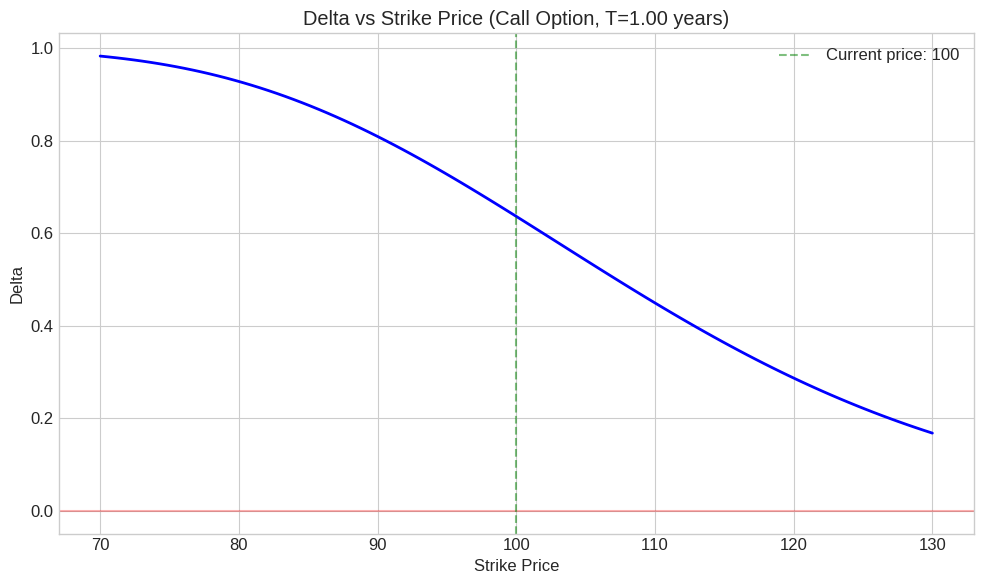

### 3D Surface of Gamma

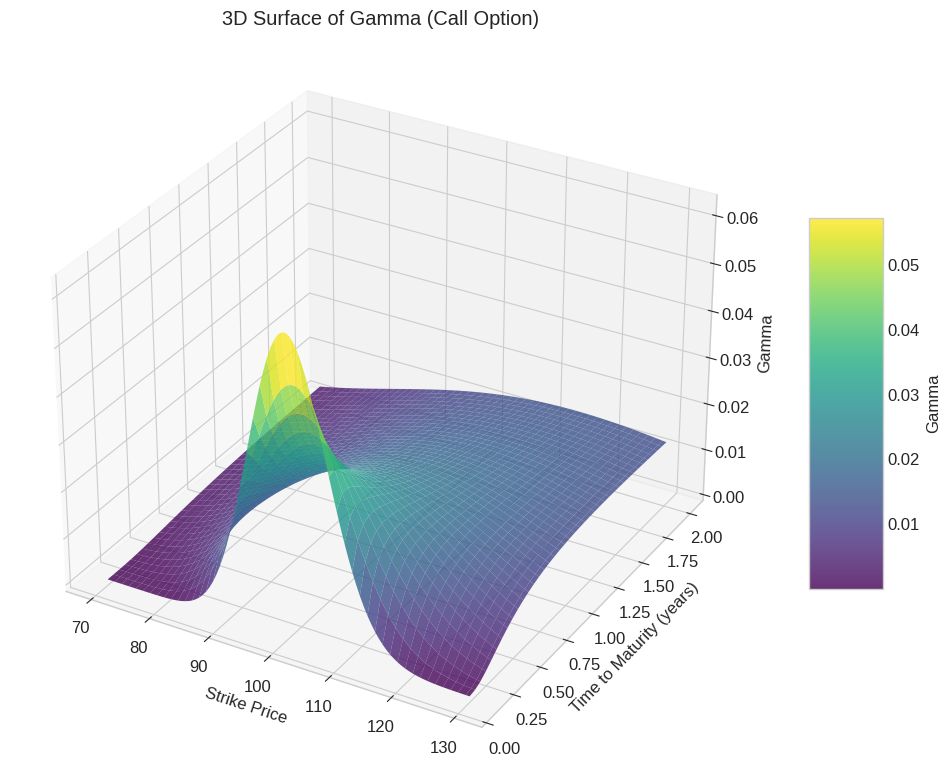

### Heatmap of Vega

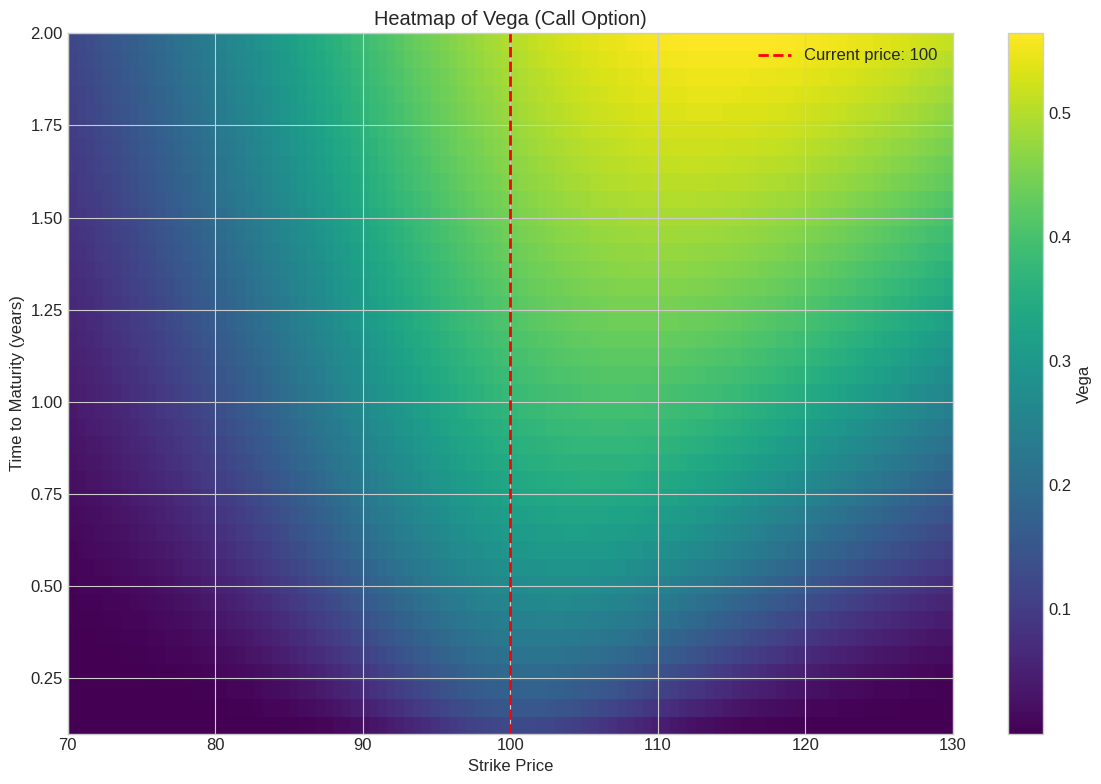

## Interactive Dashboard


    Use the controls below to explore different Greeks, option types, and parameters.
    Click the 'Update Visualisation' button to refresh the plot.
    

In [25]:
def main():
    """Main function to demonstrate the visualiser"""

    # Base parameters
    S = 100  # Current stock price
    K = 100  # Strike price
    T = 1.0  # Time to maturity (years)
    r = 0.05  # Risk-free rate
    sigma = 0.2  # Volatility



    display(Markdown("## Base Parameters"))
    display(Markdown(f"""
    - Current stock price (S): £{S}
    - Base strike price (K): £{K}
    - Base time to maturity (T): {T} years
    - Risk-free rate (r): {r*100}%
    - Volatility (σ): {sigma*100}%
    """))

    call_price = bs_call_price(S, K, T, r, sigma)
    put_price = bs_put_price(S, K, T, r, sigma)

    display(Markdown("## Sample Option Prices"))
    display(Markdown(f"""
    - At-the-money call option price: €{call_price:.4f}
    - At-the-money put option price: €{put_price:.4f}
    """))

    display(Markdown("## Sample Greeks for At-the-Money Options"))

    greeks_data = {
        'Greek': ['Delta', 'Gamma', 'Vega', 'Theta', 'Rho'],
        'Call Option': [
            f"{delta_call(S, K, T, r, sigma):.4f}",
            f"{gamma(S, K, T, r, sigma):.6f}",
            f"{vega(S, K, T, r, sigma):.6f}",
            f"{theta_call(S, K, T, r, sigma):.6f}",
            f"{rho_call(S, K, T, r, sigma):.6f}"
        ],
        'Put Option': [
            f"{delta_put(S, K, T, r, sigma):.4f}",
            f"{gamma(S, K, T, r, sigma):.6f}",
            f"{vega(S, K, T, r, sigma):.6f}",
            f"{theta_put(S, K, T, r, sigma):.6f}",
            f"{rho_put(S, K, T, r, sigma):.6f}"
        ]
    }

    display(pd.DataFrame(greeks_data))

    # Greek definitions
    display(Markdown("## Greek Definitions"))
    display(Markdown("""
    - Delta : Rate of change of option price with respect to the underlying asset price
    - Gamma : Rate of change of Delta with respect to the underlying asset price
    - Vega : Sensitivity of option price to volatility
    - Theta : Rate of time decay of option value (per day)
    - Rho : Sensitivity of option price to interest rates
    """))

    # Example visualisations
    display(Markdown("## Example Visualisations"))
    strikes = np.linspace(70, 130, 100)
    maturities = np.linspace(0.1, 2, 40)

    display(Markdown("### Delta vs Strike Price"))
    plot_2d_greek_vs_strike(delta_call, 'Delta', S, strikes, T, r, sigma, 'call')

    display(Markdown("### 3D Surface of Gamma"))
    plot_3d_greek_surface(gamma, 'Gamma', S, strikes, maturities, r, sigma)

    display(Markdown("### Heatmap of Vega"))
    plot_greek_heatmap(vega, 'Vega', S, strikes, maturities, r, sigma)

    # Interactive dashboard
    display(Markdown("## Interactive Dashboard"))
    display(Markdown("""
    Use the controls below to explore different Greeks, option types, and parameters.
    Click the 'Update Visualisation' button to refresh the plot.
    """))

    dashboard = create_dashboard(S, r, sigma)
    display(dashboard)

# Run the main function
main()


### Conclusion
By integrating Black-Scholes pricing with Greek calculations and dynamic visualisations, this notebook offers a clear, interactive way to understand how option values and sensitivities change with key parameters. This is obviously a theoretical tool, but it could be used with live data.
